# Normalization Notebook
In this notebook I normalize the whole dataset so that we do not need to do it on the fly when training the model
Below I also test some of the transforms that were generated

In [2]:
# from embed_time.transforms import complex_normalisation
import os
import skimage.io as io

data_location = r"D:\Data\DLMBL"

folder_imgs = data_location +"/"+'Control_Dataset_4TP_wMask'
metadata = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'
out_normalised = data_location + "/" +'Control_Dataset_4TP_Masked_PPNorm'
if not os.path.isdir(out_normalised):
    os.mkdir(out_normalised)

img_list = [path for path in os.listdir(folder_imgs) if path.endswith(".tif")]
img_list


['CTRLD_RR_PLATE_1_ID_A1.tif',
 'CTRLD_RR_PLATE_1_ID_A10.tif',
 'CTRLD_RR_PLATE_1_ID_A12.tif',
 'CTRLD_RR_PLATE_1_ID_A2.tif',
 'CTRLD_RR_PLATE_1_ID_A3.tif',
 'CTRLD_RR_PLATE_1_ID_A4.tif',
 'CTRLD_RR_PLATE_1_ID_A5.tif',
 'CTRLD_RR_PLATE_1_ID_A8.tif',
 'CTRLD_RR_PLATE_1_ID_A9.tif',
 'CTRLD_RR_PLATE_1_ID_B1.tif',
 'CTRLD_RR_PLATE_1_ID_B10.tif',
 'CTRLD_RR_PLATE_1_ID_B11.tif',
 'CTRLD_RR_PLATE_1_ID_B12.tif',
 'CTRLD_RR_PLATE_1_ID_B2.tif',
 'CTRLD_RR_PLATE_1_ID_B3.tif',
 'CTRLD_RR_PLATE_1_ID_B4.tif',
 'CTRLD_RR_PLATE_1_ID_B5.tif',
 'CTRLD_RR_PLATE_1_ID_B7.tif',
 'CTRLD_RR_PLATE_1_ID_B8.tif',
 'CTRLD_RR_PLATE_1_ID_B9.tif',
 'CTRLD_RR_PLATE_1_ID_C1.tif',
 'CTRLD_RR_PLATE_1_ID_C10.tif',
 'CTRLD_RR_PLATE_1_ID_C11.tif',
 'CTRLD_RR_PLATE_1_ID_C12.tif',
 'CTRLD_RR_PLATE_1_ID_C2.tif',
 'CTRLD_RR_PLATE_1_ID_C3.tif',
 'CTRLD_RR_PLATE_1_ID_C4.tif',
 'CTRLD_RR_PLATE_1_ID_C5.tif',
 'CTRLD_RR_PLATE_1_ID_C6.tif',
 'CTRLD_RR_PLATE_1_ID_C7.tif',
 'CTRLD_RR_PLATE_1_ID_C8.tif',
 'CTRLD_RR_PLATE_1_ID_C9.tif',


In [3]:
import numpy as np
img = io.imread(folder_imgs+"/"+img_list[0])
img[0][0]

array([[183.81998  ,   4.       ,   0.       ],
       [183.23395  ,   4.5434537,   0.       ],
       [182.72585  ,   4.       ,   0.       ],
       ...,
       [184.04662  ,   4.688187 ,   0.       ],
       [184.52338  ,   4.6914134,   0.       ],
       [183.96887  ,   4.       ,   0.       ]], dtype=float32)

In [4]:
img.shape

(4, 598, 712, 3)

In [5]:
all_bra = []
all_bf = []
all_mask = []
for pth in img_list:
    img = np.moveaxis(io.imread(folder_imgs+"/"+pth),3,0) 
    all_bra.append(img[1])
    all_bf.append(img[0])
    all_mask.append(img[2])
all_bra = np.array(all_bra)
print(all_bra.shape)

(312, 4, 598, 712)


In [7]:
from skimage.exposure import rescale_intensity

def rescale_bra(bra_tl,quantiles = [0.001,0.999]):
    min_max = np.quantile(bra_tl,quantiles)
    rescaled = rescale_intensity(
        bra_tl,
        in_range=(min_max[0],min_max[1]),
        out_range=(0,1)
    )
    return rescaled

out_bra = np.array([np.expand_dims(rescale_bra(bra_tl),1) for bra_tl in all_bra])
out_bra.shape

(312, 4, 1, 598, 712)

In [8]:
def rescale_bf(img,quantiles = [0.01,0.99]):
    min_max = np.quantile(img,quantiles)
    rescaled = (
        rescale_intensity(
            img,
            in_range=(min_max[0],min_max[1]),
            out_range=(0,1)) -1
    ) * -1
    rescaled = np.clip(rescaled,0,1)
    return rescaled

out_bf = [np.expand_dims(np.array([rescale_bf(img) for img in bf_tl]),1) for bf_tl in all_bf]

In [9]:
np.array(out_bf).shape

(312, 4, 1, 598, 712)

In [13]:
from skimage.morphology import disk, binary_dilation
from skimage.filters import gaussian

size = 25
strele = disk(size)

masks_dilated = np.array(
    [
        np.expand_dims(
            [gaussian(binary_dilation(msk,strele),sigma=size) for msk in msk_tl],
            1,
        ) for msk_tl in all_mask
    ]
)
masks_dilated.shape

(312, 4, 1, 598, 712)

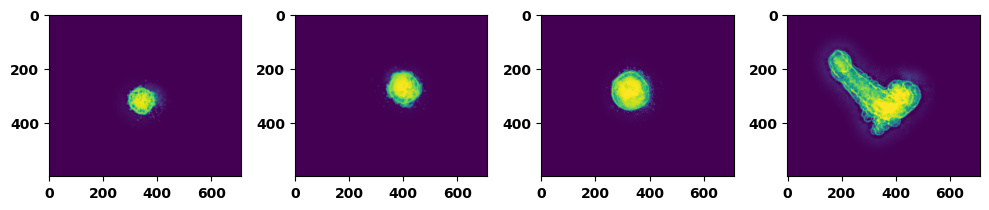

In [17]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,4,figsize=(10,5))
for i,ax in enumerate(axs):
    ax.imshow(
        (out_bf * masks_dilated)[0][i][0],
        clim = [0,1]
    )
plt.tight_layout()

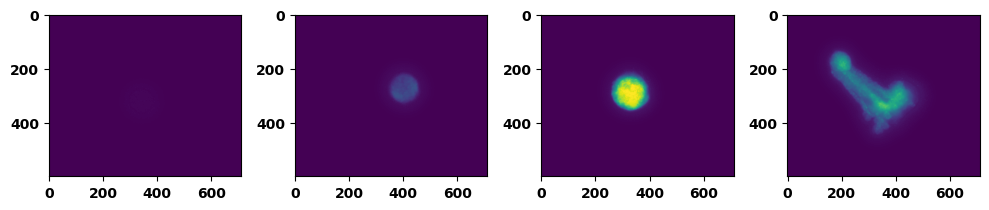

In [18]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,4,figsize=(10,5))
for i,ax in enumerate(axs):
    ax.imshow(
        (out_bra * masks_dilated)[0][i][0],
        clim = [0,1])
plt.tight_layout()

In [20]:
from tifffile import imsave

out_normalised = data_location + "/" +'Control_Dataset_4TP_Normalized_wMask'
if not os.path.isdir(out_normalised):
    os.mkdir(out_normalised)
    
for bf_tl, bra_tl, pth in zip(out_bf * masks_dilated,out_bra * masks_dilated,img_list):
    norm = np.concatenate((bf_tl,bra_tl),axis=1)
    imsave(out_normalised+"/"+pth,norm)

C:\Users\savill\AppData\Local\Temp\ipykernel_28488\1171121301.py:9: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(out_normalised+"/"+pth,norm)
